# Inventory Management - SESC Dynamics

## Supply Chain Parameters:

In [1]:
using Clp, JuMP, PyPlot, Statistics

# Define parameters
a_os = 20                 #out of stock cost coefficient
a_st = 5                  #inventory cost coefficient
a_h = 10                  #handling cost coefficient
a_sh = 5                  #Shipped (conveyor) costs
p_se = 100                #Selling price
rho = 0.005               #Interest rate
store_capacity = 50       #Store capacity
store_min = 1             #Store minimum
store_init = 30           #Initial store
store_ref = 10             #Store reference
alpha = 0.2               #Exponential smoothing weight
shipped_capacity = 100    #Shipped capacity
delivery_time = 7         #Days until arrival (min=1)
horiz = 30                #Planning horizon

H = 2*delivery_time + horiz #Minimum Past History + Planning Horizon

#Randomly generated demand of length 50 with normal distribution (μ = 10, σ = 3)

TAG = "Normal Distribution" #(Used to label figures)

d = ([8.4051, 12.9177, 8.4332, 10.5297, 12.9122, 8.7581, 8.6852, 16.0102, 12.8530, 8.7040,
        11.9468, 8.9198, 12.1177, 14.2475, 5.1865, 13.0866, 14.3739, 10.1424, 15.2388, 10.4662,
        6.2886, 3.4195, 8.9998, 12.1406, 10.9522, 11.2408, 8.2687, 10.4320, 5.0840, 7.7197,
        7.5436, 11.5592, 9.9575, 6.5334, 9.9714, 7.9306, 7.9999, 12.5924, 10.3403, 11.1951,
        12.6519, 10.5408, 11.6526, 12.0489, 13.5118, 11.4276, 14.2367, 10.0678, 9.8564, 15.1040])

d = d[1:H]

println("Horizon = ", horiz)
println("Delivery Delay = ", delivery_time)
println("Previous Demand, d_prev = ", d[1:delivery_time])
println("Simulated Demand, d = ", d[delivery_time+1:H])

Horizon = 30
Delivery Delay = 7
Previous Demand, d_prev = [8.4051, 12.9177, 8.4332, 10.5297, 12.9122, 8.7581, 8.6852]
Simulated Demand, d = [16.0102, 12.853, 8.704, 11.9468, 8.9198, 12.1177, 14.2475, 5.1865, 13.0866, 14.3739, 10.1424, 15.2388, 10.4662, 6.2886, 3.4195, 8.9998, 12.1406, 10.9522, 11.2408, 8.2687, 10.432, 5.084, 7.7197, 7.5436, 11.5592, 9.9575, 6.5334, 9.9714, 7.9306, 7.9999, 12.5924, 10.3403, 11.1951, 12.6519, 10.5408, 11.6526, 12.0489]


## One-Step Ahead Optimal Control (OSAOC): 

In [2]:
#Intialize optimal vectors 
L_osa = zeros(horiz+delivery_time+1)      
x_osa = zeros(delivery_time,horiz+delivery_time+1)
s_t_osa = zeros(horiz+delivery_time+1)
s_t_osa[1] = store_init
s_e_osa = zeros(horiz+delivery_time)
u_osa = zeros(horiz+delivery_time) 

for t in delivery_time+1:horiz+delivery_time-1 
    
    #Demand of today, d[t+1], is not known
    
    #Crop previous demand: [ d[t-D], ..., d[t+1] ] - Length D+2
    d_est = d[t-delivery_time:t+1]
    #Replaces  d[t-D] with today's demand
    d_est[1] = d[t]
    #Demand of today, d[t+1], is not known
    d_est[9] = d[t] 
    
    mST = Model(Clp.Optimizer)                            #ST holdover
    set_silent(mST)
    @variable(mST, L[1:delivery_time+3])                  #cumuLative (L for lucro) - For tracking and convenience L is declared as a optimization variable
    @variable(mST, x[1:delivery_time, 1:delivery_time+3]) #conveyor state matrix (output)
    @variable(mST, s_t[1:delivery_time+3])                #store state
    @variable(mST, s_e[1:delivery_time+2])                #selling
    @variable(mST, wp[1:delivery_time+2])                 #positive part of [available items (store -1 + receiving) minus demand]
    @variable(mST, wn[1:delivery_time+2])                 #negative part of [available items (store -1 + receiving) minus demand]
    @variable(mST, o[1:delivery_time+2])                  #ordering (control variable)
    
    
    #nonnegativity constraints & box constraints
    for k in 1:delivery_time+2
        @constraint(mST, o[k]>= 0)                        #ordering cannot be negative!      
        @constraint(mST,wp[k]>=0)  
        @constraint(mST,wn[k]>=0)
        @constraint(mST,store_min <= s_t[k] <= store_capacity)
        @constraint(mST,0<= sum(x[2:delivery_time,k]) <= shipped_capacity)
    end

    #Initial conditions
    @constraint(mST, x[:,1] .== x_osa[:,t-delivery_time])
    @constraint(mST, s_t[1]== s_t_osa[t-delivery_time])
    @constraint(mST, L[1] == L_osa[t-delivery_time])
    @constraint(mST, o[1] == u_osa[t-delivery_time])

    #dynamical constraints
    for k in 1:delivery_time+2
        for j in 1:delivery_time-1
            @constraint(mST, x[j,k+1]==x[j+1,k])
        end
        @constraint(mST, x[delivery_time,k+1]==o[k])
        @constraint(mST, s_t[k+1]== s_t[k] + x[1,k] - s_e[k])
        @constraint(mST, wp[k] - wn[k] == s_t[k] - store_min + x[1,k] - d_est[k])
        @constraint(mST, s_e[k] == d_est[k] - wn[k])
        @constraint(mST, L[k+1] == L[k] + (p_se*s_e[k] - a_os*wn[k] - a_st*s_t[k] - a_h*x[1,k] - a_sh*sum(x[2:delivery_time,k]) )*exp(-rho*(t+k-delivery_time-1) ) )
    end
    
    #Objective function
    @objective(mST, Max, L[delivery_time+3])
    optimize!(mST) 
    
    x_osa[:,t-delivery_time:t+2] = JuMP.value.(mST[:x])
    s_t_osa[t-delivery_time:t+2] = JuMP.value.(mST[:s_t])
    s_e_osa[t-delivery_time:t+1] = JuMP.value.(mST[:s_e])
    u_osa[t-delivery_time:t+1] = JuMP.value.(mST[:o])
    L_osa[t-delivery_time:t+2] = JuMP.value.(mST[:L])
    
end     

#End effect of simulation: Last D-1 instants

for t in horiz+delivery_time:H-1 
    
    d_est = d[t-delivery_time:t+1] 
    
    d_est[1] = d[t]
    d_est[9] = d[t]
    
    mST = Model(Clp.Optimizer)           #ST holdover
    set_silent(mST)
    @variable(mST, L[1:H-t+2])                  #cumuLative (L for lucro)
    @variable(mST, x[1:delivery_time, 1:H-t+2]) #conveyor state matrix(output)
    @variable(mST, s_t[1:H-t+2])                #store state
    @variable(mST, s_e[1:H-t+1])                #selling
    @variable(mST, wp[1:H-t+1])                 #positive part of [available items (store -1 + receiving) minus demand]
    @variable(mST, wn[1:H-t+1])                 #negative part of [available items (store -1 + receiving) minus demand]
    @variable(mST, o[1:H-t+1])                  #ordering (control variable)
        
    #nonnegativity constraints & box constraints
    for k in 1:H-t+1
        @constraint(mST, o[k]>=0)                               #ordering cannot be negative!
        @constraint(mST,wp[k]>=0)  
        @constraint(mST,wn[k]>=0)
        @constraint(mST,store_min <= s_t[k] <= store_capacity)
        @constraint(mST,0<=sum(x[2:delivery_time,k])<= shipped_capacity)
    end

    #Initial conditions
    @constraint(mST, x[:,1] .== x_osa[:,t-delivery_time])
    @constraint(mST, s_t[1]== s_t_osa[t-delivery_time])
    @constraint(mST, L[1] == L_osa[t-delivery_time])
    @constraint(mST, o[1] == u_osa[t-delivery_time])

    #dynamical constraints
    for k in 1:H-t+1
        for j = 1:delivery_time-1
            @constraint(mST, x[j,k+1]==x[j+1,k])
        end
        @constraint(mST, x[delivery_time,k+1]==o[k])
        @constraint(mST, s_t[k+1]== s_t[k] + x[1,k] - s_e[k])
        @constraint(mST, wp[k] - wn[k] == s_t[k] - store_min + x[1,k] - d_est[k])
        @constraint(mST, s_e[k] == d_est[k] - wn[k])
        @constraint(mST, L[k+1] == L[k] + (p_se*s_e[k] - a_os*wn[k] - a_st*s_t[k] - a_h*x[1,k] - a_sh*sum(x[2:delivery_time,k]) )*exp(-rho*(t+k-delivery_time-1) ) )
    end
    
    #Objective function
    @objective(mST, Max, L[H-t+2])
    optimize!(mST) 
    
    x_osa[:,t-delivery_time:horiz+delivery_time+1] = JuMP.value.(mST[:x])
    s_t_osa[t-delivery_time:horiz+delivery_time+1] = JuMP.value.(mST[:s_t])
    s_e_osa[t-delivery_time:horiz+delivery_time] = JuMP.value.(mST[:s_e])
    u_osa[t-delivery_time:horiz+delivery_time] = JuMP.value.(mST[:o])
    L_osa[t-delivery_time:horiz+delivery_time+1] = JuMP.value.(mST[:L])
end 

x_osa = x_osa[:,1:horiz+1]
s_t_osa = s_t_osa[1:horiz+1]
s_e_osa = s_e_osa[1:horiz]
u_osa = u_osa[1:horiz]
L_osa = L_osa[1:horiz+1]

s_h_osa = transpose(sum(x_osa[2:delivery_time,:],dims=1))
LS_osa = d[delivery_time+1:horiz+delivery_time] - s_e_osa

println("Cumulative profit = ", round.(L_osa, digits=2), "\n")
println("Optimal ordering sequence o* = ", round.(u_osa, digits=2), "\n")
println("Receiving = ", round.(x_osa[1,:], digits=2), "\n")
println("Selling = ", round.(s_e_osa, digits=2), "\n")
println("Shipping = ", round.(s_h_osa[:], digits=2), "\n")
println("Store = ", round.(s_t_osa, digits=2), "\n")
println("Lost Sales = ", round.(LS_osa, digits=2), "\n")

Cumulative profit = [0.0, 1443.78, 2647.04, 2407.27, 2042.18, 1715.74, 1270.89, 758.68, 364.93, 1178.75, 2002.97, 2009.35, 2674.03, 2800.72, 2976.38, 2877.87, 3366.77, 4120.42, 4770.17, 5476.0, 5873.87, 6494.11, 6671.21, 6935.48, 7303.54, 8009.51, 8600.15, 8875.23, 9465.74, 9884.24, 9968.63]

Optimal ordering sequence o* = [0.0, 16.01, 9.7, 4.56, 11.95, 5.89, 12.12, 14.25, 0.0, 13.09, 14.37, 5.91, 15.24, 5.69, 2.11, 0.55, 9.0, 12.14, 9.76, 11.24, 5.3, 10.43, 0.0, 7.72, 7.37, 11.56, 8.36, 3.11, 9.97, 5.89]

Receiving = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.01, 9.7, 4.56, 11.95, 5.89, 12.12, 14.25, 0.0, 13.09, 14.37, 5.91, 15.24, 5.69, 2.11, 0.55, 9.0, 12.14, 9.76, 11.24, 5.3, 10.43, 0.0, 7.72]

Selling = [16.01, 12.85, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 13.09, 12.62, 4.56, 11.95, 5.89, 6.29, 3.42, 9.0, 12.14, 10.95, 11.24, 8.27, 10.43, 5.08, 6.5, 7.54, 11.56, 9.96, 6.53, 9.97, 7.93, 4.38]

Shipping = [0.0, 0.0, 16.01, 25.71, 30.26, 42.21, 48.1, 60.22, 58.46, 48.76, 57.29, 59.72, 59.74

## APIOBPCS (TOSETTI 2008)

### Controller: 

$$o(k) = \hat{d}(k) + \frac{1}{T_i} \left(I_{ref}(k) - I(k)\right) + \frac{1}{T_w} \left(T_p \, \hat{d}(k) - WIP(k)\right)$$

In [3]:
#Tosetti Basic Setting
T_p = 7
T_i = 7
T_w = 7

#Optimal Fixed Gains obtained by f_min_con

#Normal Distribution (Optimized)
#μ = 10, σ = 3 
#T_p =  5.03   
#T_i = 16.71   
#T_w = 15.63

L_tos = zeros(H+1)
LS_tos = zeros(H)
x_tos = zeros(delivery_time,H+1)
s_h_tos = zeros(H+1)
s_t_tos = zeros(H+1)
s_t_tos[1:delivery_time+1] = store_init*ones(delivery_time+1)
s_e_tos = zeros(H)
u_tos = zeros(H)

for k in delivery_time+1:H
  
    #Yesterday's Demand
    d_est = d[k-1]
    
    #control action
    if k > delivery_time+1
        u_tos[k] = d_est + 1/T_i * (store_ref - s_t_tos[k]) + 1/T_w * (T_p * d_est - s_h_tos[k])
    else
        u_tos[k] = 0 #utos[1] = 0 for all simulated controllers (including OSA and the Omni. solution)   
    end
    #
    if u_tos[k] < 0  #no refund policy (u ≥ 0)
       u_tos[k] = 0
    end
    #
    
    s_e_tos[k] = min(s_t_tos[k] + x_tos[1,k] - store_min, d[k])     #evaluate selling 
    s_t_tos[k+1] = s_t_tos[k] + x_tos[1,k] - s_e_tos[k] #update inventory level
    
    #update conveyor state
    for j = 1:delivery_time-1                          
        x_tos[j,k+1]=x_tos[j+1,k]
    end
    x_tos[delivery_time,k+1] = u_tos[k]
    
    #update shipping
    s_h_tos[k+1] = sum(x_tos[2:delivery_time,k+1])
    
    #Penalize Store Violation
    if s_t_tos[k+1] > store_capacity
        P_Store = 20*(s_t_tos[k+1] - store_capacity)
    else
        P_Store = 0
    end
        
    #Penalize Shipping Violation
    if s_h_tos[k+1] > shipped_capacity
        P_Ship = 20*(s_h_tos[k+1] - shipped_capacity)
    else
        P_Ship = 0
    end
    
    Penalty = P_Store + P_Ship
    
    #evaluate Lost Sales
    LS_tos[k] = d[k] - s_e_tos[k]
    
    #evaluate Profit
    L_tos[k+1] = L_tos[k] - Penalty +(p_se*s_e_tos[k] -a_os*LS_tos[k] -a_st*s_t_tos[k]-a_h*x_tos[1,k]-a_sh*s_h_tos[k])*exp(-rho*(k-delivery_time))
end

#Trimming (only show the simulated period) [delivery_time+1:H] = [1:horiz]

x_tos = x_tos[:,delivery_time+1:horiz+delivery_time+1]
s_h_tos = s_h_tos[delivery_time+1:horiz+delivery_time+1]
s_t_tos = s_t_tos[delivery_time+1:horiz+delivery_time+1]
L_tos = L_tos[delivery_time+1:horiz+delivery_time+1]
LS_tos = LS_tos[delivery_time+1:horiz+delivery_time]
s_e_tos = s_e_tos[delivery_time+1:horiz+delivery_time]
u_tos = u_tos[delivery_time+1:horiz+delivery_time]

println("Cumulative profit = ", round.(L_tos, digits=2), "\n")
println("Optimal ordering sequence o* = ", round.(u_tos, digits=2), "\n")
println("Receiving = ", round.(x_tos[1,:], digits=2), "\n")
println("Selling = ", round.(s_e_tos, digits=2), "\n")
println("Shipping = ", round.(s_h_tos[:], digits=2), "\n")
println("Store = ", round.(s_t_tos, digits=2), "\n")
println("Lost Sales = ", round.(LS_tos, digits=2), "\n")

Cumulative profit = [0.0, 1443.78, 2647.04, 2331.21, 1827.8, 1332.35, 700.13, -32.57, -623.65, -85.06, 678.2, 1084.4, 1914.97, 2367.5, 2368.52, 2083.7, 2401.87, 2975.34, 3457.01, 3987.16, 4178.25, 4616.24, 4636.4, 4876.58, 5102.61, 5663.41, 6124.38, 6256.78, 6704.54, 6990.68, 7306.21]

Optimal ordering sequence o* = [0.0, 31.45, 22.48, 10.99, 15.91, 7.58, 12.89, 15.31, 0.0, 15.88, 16.6, 7.92, 17.97, 8.11, 0.0, 0.0, 7.12, 14.22, 10.13, 12.31, 4.38, 8.41, 0.0, 4.63, 5.71, 13.99, 10.52, 1.97, 10.57, 4.91]

Receiving = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.45, 22.48, 10.99, 15.91, 7.58, 12.89, 15.31, 0.0, 15.88, 16.6, 7.92, 17.97, 8.11, 0.0, 0.0, 7.12, 14.22, 10.13, 12.31, 4.38, 8.41, 0.0, 4.63]

Selling = [16.01, 12.85, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 13.09, 14.37, 10.14, 15.24, 10.47, 6.29, 3.42, 9.0, 12.14, 10.95, 11.24, 8.27, 10.43, 5.08, 7.72, 7.54, 11.56, 9.96, 6.53, 9.97, 7.93, 8.0]

Shipping = [0.0, 0.0, 31.45, 53.93, 64.92, 80.82, 88.4, 101.3, 85.15, 62.68, 67.57, 68.26, 68.6

## (s,S) Policy

In [4]:
#Normal Distribution
#μ = 10, σ = 3 

s =  7 + store_min
S = 13 + store_min

#Normal Distribution (Optimized)
#μ = 10, σ = 3 

#s =  9.27
#S = 10.06

L_ssp = zeros(H+1)
LS_ssp = zeros(H)
x_ssp = zeros(delivery_time,H+1)
s_h_ssp = zeros(H+1)
s_t_ssp = zeros(H+1)
s_t_ssp[1:delivery_time+1] = store_init*ones(delivery_time+1)
s_e_ssp = zeros(H)
u_ssp = zeros(H)


for k in delivery_time+1:H
    
    #control action
    if s_t_ssp[k] <= s
        u_ssp[k] = S - s_t_ssp[k]
    else
        u_ssp[k] = 0   
    end
        
    s_e_ssp[k] = min(s_t_ssp[k] + x_ssp[1,k] - store_min, d[k])     #evaluate selling 
    s_t_ssp[k+1] = s_t_ssp[k] + x_ssp[1,k] - s_e_ssp[k] #update inventory level
    
    #update conveyor state
    for j = 1:delivery_time-1                          
        x_ssp[j,k+1]=x_ssp[j+1,k]
    end
    x_ssp[delivery_time,k+1]=u_ssp[k]
    
    #update shipping
    s_h_ssp[k+1] = sum(x_ssp[2:delivery_time,k+1])
    
    #Penalize Store Violation
    if s_t_ssp[k+1] > store_capacity
        P_Store = 20*(s_t_ssp[k+1] - store_capacity)
    else
        P_Store = 0
    end
        
    #Penalize Shipping Violation
    if s_h_ssp[k+1] > shipped_capacity
        P_Ship = 20*(s_h_ssp[k+1] - shipped_capacity)
    else
        P_Ship = 0
    end
    
    Penalty = P_Store + P_Ship
    
    #evaluate Lost Sales
    LS_ssp[k] = d[k] - s_e_ssp[k]
    
    #evaluate Profit
    L_ssp[k+1] = L_ssp[k] - Penalty +(p_se*s_e_ssp[k] -a_os*LS_ssp[k] -a_st*s_t_ssp[k]-a_h*x_ssp[1,k]-a_sh*s_h_ssp[k])*exp(-rho*(k-delivery_time))
end

#Trimming (only show the simulated period) [delivery_time+1:H] = [1:horiz]

x_ssp = x_ssp[:,delivery_time+1:horiz+delivery_time+1]
s_h_ssp = s_h_ssp[delivery_time+1:horiz+delivery_time+1]
s_t_ssp = s_t_ssp[delivery_time+1:horiz+delivery_time+1]
L_ssp = L_ssp[delivery_time+1:horiz+delivery_time+1]
LS_ssp = LS_ssp[delivery_time+1:horiz+delivery_time]
s_e_ssp = s_e_ssp[delivery_time+1:horiz+delivery_time]
u_ssp = u_ssp[delivery_time+1:horiz+delivery_time]

println("Cumulative profit = ", round.(L_ssp, digits=2), "\n")
println("Optimal ordering sequence o* = ", round.(u_ssp, digits=2), "\n")
println("Receiving = ", round.(x_ssp[1,:], digits=2), "\n")
println("Selling = ", round.(s_e_ssp, digits=2), "\n")
println("Shipping = ", round.(s_h_ssp[:], digits=2), "\n")
println("Store = ", round.(s_t_ssp, digits=2), "\n")
println("Lost Sales = ", round.(LS_ssp, digits=2), "\n")

Cumulative profit = [0.0, 1443.78, 2647.04, 2486.12, 2183.98, 1878.99, 1450.37, 919.99, 503.93, -123.25, 573.5, 1036.56, 1963.81, 2463.09, 2561.44, 2376.61, 2723.61, 3398.7, 4017.29, 4721.83, 5194.66, 5908.52, 6230.57, 6808.6, 7402.37, 8049.89, 7870.63, 7695.3, 7404.57, 7094.36, 6728.56]

Optimal ordering sequence o* = [0.0, 0.0, 12.86, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 10.14, 12.38, 9.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 13.0, 13.0, 13.0, 13.0]

Receiving = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.86, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 10.14, 12.38, 9.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Selling = [16.01, 12.85, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.86, 10.14, 15.24, 10.47, 6.29, 3.42, 9.0, 12.14, 10.95, 11.24, 8.27, 10.43, 5.08, 7.72, 7.54, 8.43, 0.0, 0.0, 0.0, 0.0, 0.0]

Shipping = [0.0, 0.0, 0.0, 12.86, 25.86, 38.86, 51.86, 64.86, 77.86, 78.0, 78.0, 78.0, 75.14, 74.52, 71.37, 58.37, 45.37, 32.37, 22.2

## Omniscient Solution

In [5]:
mST = Model(Clp.Optimizer)                                  #ST holdover
set_silent(mST)
@variable(mST, L[1:horiz+delivery_time+1])                  #cumuLative (L for lucro)
@variable(mST, x[1:delivery_time, 1:horiz+delivery_time+1]) #conveyor state matrix (output)
@variable(mST, s_t[1:horiz+delivery_time+1])                #store state
@variable(mST, s_e[1:horiz+delivery_time])                  #selling
@variable(mST, wp[1:horiz+delivery_time])                   #positive part of [available items (store -1 + receiving) minus demand]
@variable(mST, wn[1:horiz+delivery_time])                   #negative part of [available items (store -1 + receiving) minus demand]
@variable(mST, o[1:horiz+delivery_time])                    #ordering (control variable)

#nonnegativity constraints & box constraints
for t in 1:horiz+delivery_time
    @constraint(mST, o[t]>= 0)                              #ordering cannot be negative!
    @constraint(mST,wp[t]>=0)  
    @constraint(mST,wn[t]>=0)
    @constraint(mST,store_min <= s_t[t] <= store_capacity)
    @constraint(mST,0<=sum(x[2:delivery_time,t])<= shipped_capacity)
end

#Initial conditions
@constraint(mST, x[:,1] .== zeros(delivery_time,1))
@constraint(mST, s_t[1]==store_init)
@constraint(mST, L[1]==0)
@constraint(mST,o[1]==0)

#dynamical constraints
for t in 1:horiz+delivery_time
    for j = 1:delivery_time-1
        @constraint(mST, x[j,t+1]==x[j+1,t])
    end
    @constraint(mST, x[delivery_time,t+1]==o[t])
    @constraint(mST, s_t[t+1]== s_t[t] + x[1,t] - s_e[t])
    @constraint(mST, wp[t] - wn[t] == s_t[t] - store_min + x[1,t] - d[t+delivery_time])
    @constraint(mST, s_e[t] == d[t+delivery_time] - wn[t])
    @constraint(mST, L[t+1] == L[t] + (p_se*s_e[t] - a_os*wn[t] - a_st*s_t[t] - a_h*x[1,t] - a_sh*sum(x[2:delivery_time,t]) )*exp(-rho*t))
end

#Objective function
@objective(mST, Max, L[horiz+delivery_time+1])
optimize!(mST)

x_omn = JuMP.value.(x[:,1:horiz+1])
s_t_omn = JuMP.value.(s_t[1:horiz+1])
s_e_omn = JuMP.value.(s_e[1:horiz])
u_omn = JuMP.value.(o[1:horiz])
L_omn = JuMP.value.(L[1:horiz+1])

s_h_omn = transpose(sum(x_omn[2:delivery_time,:], dims=1))
LS_omn = d[delivery_time+1:H-delivery_time] - s_e_omn

println("Cumulative profit = ", round.(L_omn, digits=2), "\n")
println("Optimal ordering sequence o* = ", round.(u_omn, digits=2), "\n")
println("Receiving = ", round.(x_omn[1,:], digits=2), "\n")
println("Selling = ", round.(s_e_omn, digits=2), "\n")
println("Shipping = ", round.(s_h_omn[:], digits=2), "\n")
println("Store = ", round.(s_t_omn, digits=2), "\n")
println("Lost Sales = ", round.(LS_omn, digits=2), "\n")

Cumulative profit = [0.0, 1443.78, 2647.04, 2421.67, 2047.98, 1685.74, 1189.29, 603.66, 164.86, 999.59, 1965.91, 2557.51, 3598.31, 4227.79, 4494.33, 4487.45, 4962.29, 5714.7, 6381.19, 7066.53, 7498.77, 8121.7, 8288.45, 8664.87, 9023.33, 9694.38, 10233.83, 10480.96, 10984.21, 11314.78, 11633.35]

Optimal ordering sequence o* = [0.0, 13.09, 14.37, 10.14, 15.24, 10.47, 6.29, 3.42, 9.0, 12.14, 10.95, 11.24, 8.27, 10.43, 5.08, 7.72, 7.54, 11.56, 9.96, 6.53, 9.97, 7.93, 8.0, 12.59, 10.34, 11.2, 12.65, 10.54, 11.65, 12.05]

Receiving = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.09, 14.37, 10.14, 15.24, 10.47, 6.29, 3.42, 9.0, 12.14, 10.95, 11.24, 8.27, 10.43, 5.08, 7.72, 7.54, 11.56, 9.96, 6.53, 9.97, 7.93, 8.0, 12.59]

Selling = [16.01, 12.85, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 13.09, 14.37, 10.14, 15.24, 10.47, 6.29, 3.42, 9.0, 12.14, 10.95, 11.24, 8.27, 10.43, 5.08, 7.72, 7.54, 11.56, 9.96, 6.53, 9.97, 7.93, 8.0]

Shipping = [0.0, 0.0, 13.09, 27.46, 37.6, 52.84, 63.31, 69.6, 59.93, 54.56, 56.

## Efficiency: 

In [6]:
#Cumulated Profit (L)
Eta_tos = L_tos[2:horiz+1]./L_omn[2:horiz+1] #η (APIOBPCS)
Eta_osa = L_osa[2:horiz+1]./L_omn[2:horiz+1] #η (OSA)
Eta_ssp = L_ssp[2:horiz+1]./L_omn[2:horiz+1] #η (s,S)

println("APIOBPCS Controller = ",round(Eta_tos[horiz]*100, digits=2),"%")
println("OSAO Controller = ",round(Eta_osa[horiz]*100, digits=2),"%")
println("(s,S) Controller = ",round(Eta_ssp[horiz]*100, digits=2),"%")

APIOBPCS Controller = 62.8%
OSAO Controller = 85.69%
(s,S) Controller = 57.84%


## Stock Level: 

In [7]:
st_mean_tos = round(mean(s_t_tos[delivery_time:horiz]), digits=2)

st_mean_osa = round(mean(s_t_osa[delivery_time:horiz]), digits=2)

st_mean_ssp = round(mean(s_t_ssp[delivery_time:horiz]), digits=2)

st_max_tos = round(maximum(s_t_tos[delivery_time:horiz]), digits=2)

st_max_osa = round(maximum(s_t_osa[delivery_time:horiz]), digits=2)

st_max_ssp = round(maximum(s_t_ssp[delivery_time:horiz]), digits=2)

println("Average Stock Level: \n")
println("APIOBPCS Controller = ", st_mean_tos)
println("OSAO Controller = ", st_mean_osa)
println("(s,S) Controller = ", st_mean_ssp, "\n")

println("Max Stock Level: \n")
println("APIOBPCS Controller = ", st_max_tos)
println("OSAO Controller = ", st_max_osa)
println("(s,S) Controller = ", st_max_ssp, "\n")

Average Stock Level: 

APIOBPCS Controller = 32.83
OSAO Controller = 5.46
(s,S) Controller = 11.06

Max Stock Level: 

APIOBPCS Controller = 51.35
OSAO Controller = 17.66
(s,S) Controller = 30.37



## Comparison Plots:

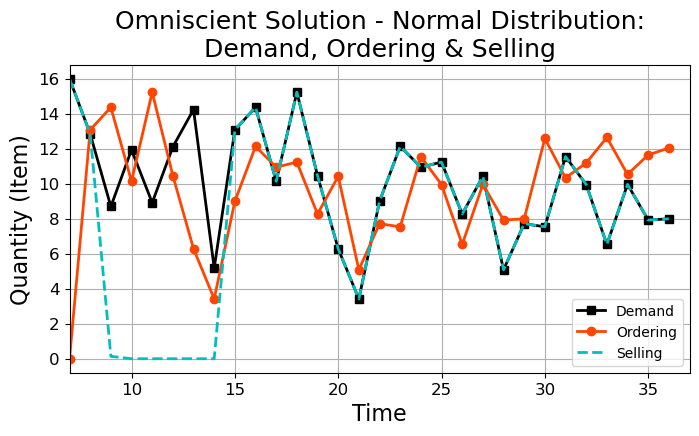

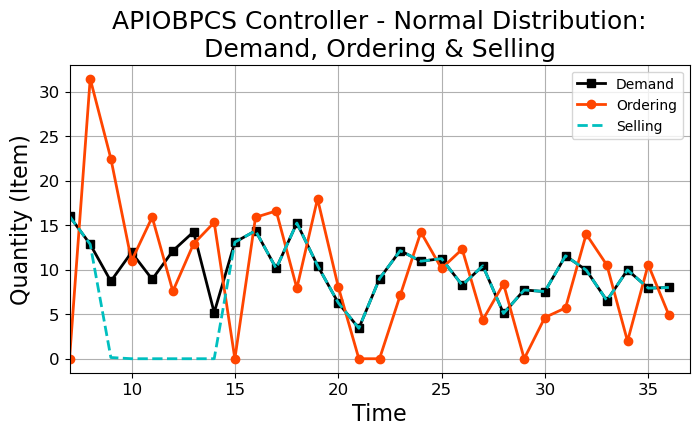

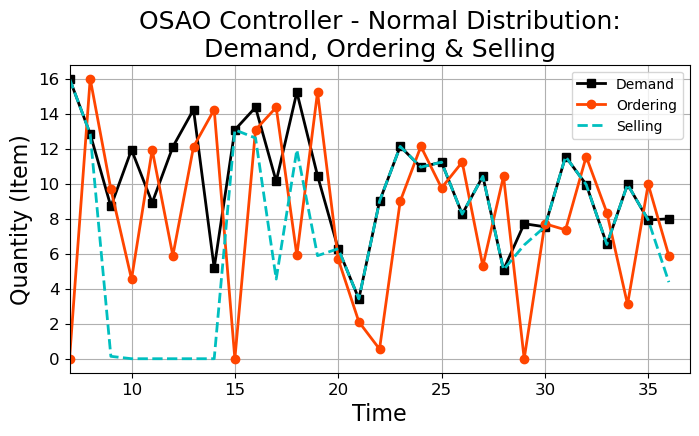

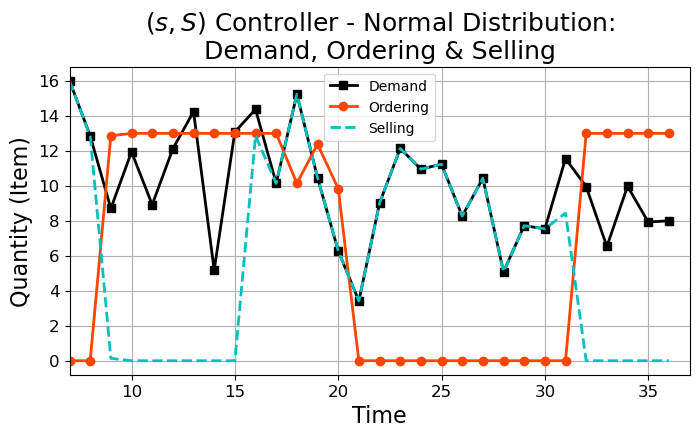

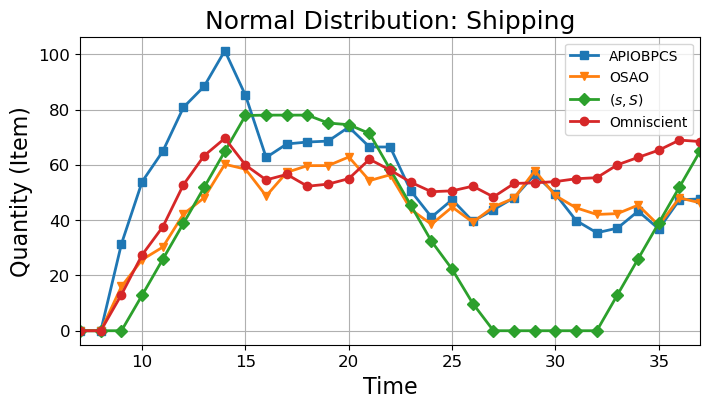

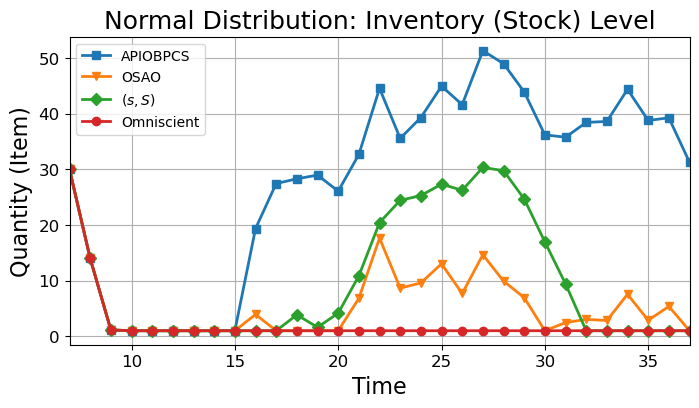

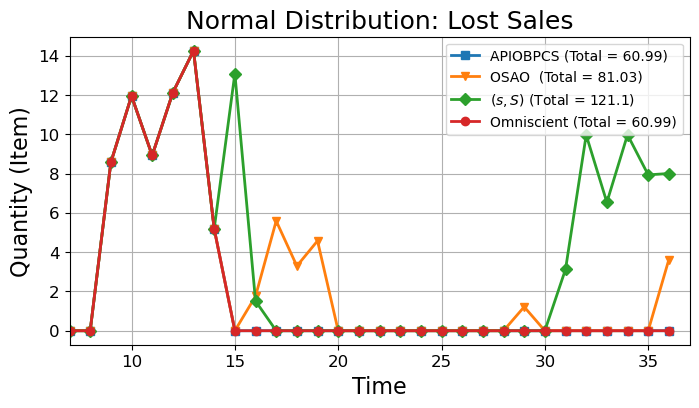

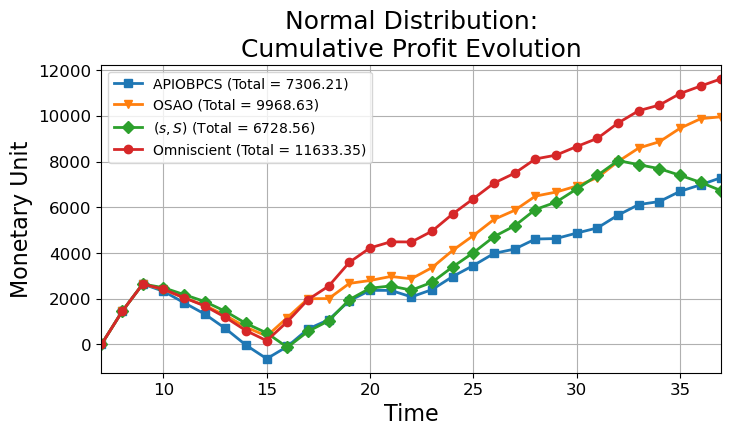

In [8]:
PyPlot.svg(true)

save_files = false #true - save all figures and data / false - do not save

d_sim = d[delivery_time+1:H-delivery_time]
t1 = Array((delivery_time:horiz+delivery_time-1))
t2 = Array((delivery_time:horiz+delivery_time))

#Lost Sales Total
LS_total_tos = round.(sum(LS_tos), digits=2) #APIOBPCS
LS_total_osa = round.(sum(LS_osa), digits=2) #OSA 
LS_total_omn = round.(sum(LS_omn), digits=2) #Omniscient
LS_total_ssp = round.(sum(LS_ssp), digits=2) #(s,S) Policy

#Cumulative L (Final)
L_total_tos = round(L_tos[horiz+1], digits=2) #APIOBPCS
L_total_osa = round(L_osa[horiz+1], digits=2) #OSA 
L_total_omn = round(L_omn[horiz+1], digits=2) #Omniscient
L_total_ssp = round(L_ssp[horiz+1], digits=2) #(s,S) Policy

objective = "Profit"

Ex = "E1"
#Ex = "E2"

figure(figsize=(8,4))
title("Omniscient Solution - $(TAG):\nDemand, Ordering & Selling", fontsize=18)
#title("Omniscient Solution: Demand, Ordering & Selling", fontsize=20)
plot(t1,d_sim,"ks-", linewidth=2)
plot(t1,u_omn,"o-", linewidth=2, color="orangered")
plot(t1,s_e_omn,"c--", linewidth=2)
grid("on")
legend(["Demand","Ordering","Selling"], loc="best");
xlabel("Time",fontsize=16)
ylabel("Quantity (Item)",fontsize=16)
xlim((delivery_time,horiz+delivery_time))
xticks(fontsize=12)
yticks(fontsize=12)
if save_files
    savefig("$(Ex)_omni.eps", bbox_inches="tight")
end
#
figure(figsize=(8,4))
title("APIOBPCS Controller - $(TAG):\nDemand, Ordering & Selling", fontsize=18)
#title("APIOBPCS: Demand, Ordering & Selling", fontsize=20)
plot(t1,d_sim,"ks-", linewidth=2)
plot(t1,u_tos,"o-", linewidth=2, color="orangered")
plot(t1,s_e_tos,"c--", linewidth=2)
grid("on")
legend(["Demand","Ordering","Selling"], loc="best");
xlabel("Time",fontsize=16)
ylabel("Quantity (Item)",fontsize=16)
xlim((delivery_time,horiz+delivery_time))
xticks(fontsize=12)
yticks(fontsize=12)
if save_files
    savefig("$(Ex)_apiobpcs.eps", bbox_inches="tight")
end
#
figure(figsize=(8,4))
title("OSAO Controller - $(TAG):\nDemand, Ordering & Selling", fontsize=18)
#title("OSAO: Demand, Ordering & Selling", fontsize=20)
plot(t1,d_sim,"ks-", linewidth=2)
plot(t1,u_osa,"o-", linewidth=2, color="orangered")
plot(t1,s_e_osa,"c--", linewidth=2)
grid("on")
legend(["Demand","Ordering","Selling"], loc="best");
xlabel("Time",fontsize=16)
ylabel("Quantity (Item)",fontsize=16)
xlim((delivery_time,horiz+delivery_time))
xticks(fontsize=12)
yticks(fontsize=12)
if save_files
    savefig("$(Ex)_osao.eps", bbox_inches="tight")
end
#
figure(figsize=(8,4))
title("\$(s,S)\$ Controller - $(TAG):\nDemand, Ordering & Selling", fontsize=18)
#title("\$(s,S)\$ policy: Demand, Ordering & Selling", fontsize=20)
plot(t1,d_sim,"ks-", linewidth=2)
plot(t1,u_ssp,"o-", linewidth=2, color="orangered")
plot(t1,s_e_ssp,"c--", linewidth=2)
grid("on")
legend(["Demand","Ordering","Selling"], loc="best");
xlabel("Time",fontsize=16)
ylabel("Quantity (Item)",fontsize=16)
xlim((delivery_time,horiz+delivery_time))
xticks(fontsize=12)
yticks(fontsize=12)
if save_files
    savefig("$(Ex)_ss.eps", bbox_inches="tight")
end
#
figure(figsize=(8,4))
title("$(TAG): Shipping", fontsize=18)
#title("Shipping", fontsize=20)
plot(t2,s_h_tos,"s-", color="tab:blue", linewidth=2)
plot(t2,s_h_osa,"v-", color="tab:orange", linewidth=2)
plot(t2,s_h_ssp,"D-", color="tab:green", linewidth=2)
plot(t2,s_h_omn,"o-", color="tab:red", linewidth=2)
grid("on")
legend(["APIOBPCS", "OSAO", "\$(s,S)\$", "Omniscient"], loc="best");
xlabel("Time",fontsize=16)
ylabel("Quantity (Item)",fontsize=16)
xlim((delivery_time,horiz+delivery_time))
xticks(fontsize=12)
yticks(fontsize=12)
if save_files
    savefig("$(Ex)_ship.eps", bbox_inches="tight")
end
#
figure(figsize=(8,4))
title("$(TAG): Inventory (Stock) Level", fontsize=18)
#title("Inventory (Stock) Level", fontsize=20)
plot(t2,s_t_tos,"s-", color="tab:blue", linewidth=2)
plot(t2,s_t_osa,"v-", color="tab:orange", linewidth=2)
plot(t2,s_t_ssp,"D-", color="tab:green", linewidth=2)
plot(t2,s_t_omn,"o-", color="tab:red", linewidth=2)
grid("on")
legend(["APIOBPCS", "OSAO", "\$(s,S)\$", "Omniscient"], loc="best");
#legend(["APIOBPCS", "OSAO", "\$(s,S)\$", "Omniscient"], bbox_to_anchor=(0.1,0.99));
xlabel("Time",fontsize=16)
ylabel("Quantity (Item)",fontsize=16)
xlim((delivery_time,horiz+delivery_time))
xticks(fontsize=12)
yticks(fontsize=12)
if save_files
    savefig("$(Ex)_store.eps", bbox_inches="tight")
end
#
figure(figsize=(8,4))
title("$(TAG): Lost Sales", fontsize=18)
#title("Lost Sales", fontsize=20)
plot(t1,LS_tos,"s-", color="tab:blue", linewidth=2)
plot(t1,LS_osa,"v-", color="tab:orange", linewidth=2)
plot(t1,LS_ssp,"D-", color="tab:green", linewidth=2)
plot(t1,LS_omn,"o-", color="tab:red", linewidth=2)
grid("on")
legend(["APIOBPCS (Total = $(LS_total_tos))", "OSAO  (Total = $(LS_total_osa))", "\$(s,S)\$ (Total = $(LS_total_ssp))", "Omniscient (Total = $(LS_total_omn))"], loc="best");
xlabel("Time",fontsize=16)
ylabel("Quantity (Item)",fontsize=16)
xlim((delivery_time,horiz+delivery_time))
xticks(fontsize=12)
yticks(fontsize=12)
if save_files
    savefig("$(Ex)_lost_sales.eps", bbox_inches="tight")
end
#
figure(figsize=(8,4))
title("$(TAG):\nCumulative $(objective) Evolution", fontsize=18)
#title("Cumulative $(objective) Evolution", fontsize=20)
plot(t2,L_tos,"s-", color="tab:blue", linewidth=2)
plot(t2,L_osa,"v-", color="tab:orange", linewidth=2)
plot(t2,L_ssp,"D-", color="tab:green", linewidth=2)
plot(t2,L_omn,"o-", color="tab:red", linewidth=2)
grid("on")
legend(["APIOBPCS (Total = $(L_total_tos))", "OSAO (Total = $(L_total_osa))", "\$(s,S)\$ (Total = $(L_total_ssp))", "Omniscient (Total = $(L_total_omn))"], loc="best");
xlabel("Time",fontsize=16)
ylabel("Monetary Unit",fontsize=16)
xlim((delivery_time,horiz+delivery_time))
xticks(fontsize=12)
yticks(fontsize=12)
if save_files
    savefig("$(Ex)_profit.eps", bbox_inches="tight")
end